In our setting, we have limited experimental data and a scoring model. This notebook presents an example where we apply a correction to the scoring model using experimental data and compare it with a causal-effect model learned from scratch using the same data.

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("..")
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import copy
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV, train_test_split

# Causal tree
from deconfounder.causal_tree import CausalTree

# Deconfounder
from deconfounder.deconfound_estimator import DeconfoundEstimator
from deconfounder.deconfound_classifier import DeconfoundClassifier
from deconfounder.deconfound_ranker import DeconfoundRanker

# Evaluation metrics
from metrics import mean_squared_error, causal_impact, auuc_score, uplift_curve

In [2]:
## Data generation functions

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class DataGenerator:

    def __init__(
        self, 
        n_features, 
        alpha_0=1.0,
        beta_0=0.0,
        theta=1.0,
        noise_scale_c=0.0, 
        noise_scale_y0=0.0,
        noise_scale_a=0.0,
        noise_scale_x=0.0
    ):
      
        self.n_features = n_features
        self.alpha_0 = alpha_0
        self.beta_0 = beta_0
        self.theta = theta
        self.noise_scale_c = noise_scale_c
        self.noise_scale_y0 = noise_scale_y0
        self.noise_scale_a = noise_scale_a
        self.noise_scale_x = noise_scale_x

    def reset_params(
        self,         
        n_features, 
        alpha_0=1.0,
        beta_0=0.0,
        theta=1.0,
        noise_scale_c=0.0, 
        noise_scale_y0=0.0,
        noise_scale_a=0.0,
        noise_scale_x=0.0
    ):

        self.n_features = n_features
        self.alpha_0 = alpha_0
        self.beta_0 = beta_0
        self.theta = theta
        self.noise_scale_c = noise_scale_c
        self.noise_scale_y0 = noise_scale_y0
        self.noise_scale_a = noise_scale_a
        self.noise_scale_x = noise_scale_x
        
    def reset_coef(self):
        '''
        Return:
            - beta: Coefficient of X for C.
            - alpha: Coeficient of U for X.
        '''
        k = self.n_features
        theta = self.theta
        
        beta = np.random.uniform(-1, 1, size=k)  

        noise_scale_a = self.noise_scale_a
        noise_a = np.random.normal(0, noise_scale_a, size=k)
        alpha = theta * beta + noise_a

        self.beta = beta
        self.alpha = alpha

    def cate(self, X):

        beta = self.beta
        beta_0 = self.beta_0
        x_beta = np.squeeze(np.dot(X, beta[:, np.newaxis]))
        eff = x_beta + beta_0
        return eff

    def control_outcome(self, u):

        alpha_0 = self.alpha_0
        noise_scale = self.noise_scale_y0
        noise_y0 = np.random.normal(0, noise_scale, size=u.shape[0])
        y0 = u * alpha_0 + noise_y0
        return y0
    
    def covariate(self, u):

        n = u.shape[0]
        k = self.n_features
        alpha = self.alpha
        noise_scale = self.noise_scale_x
        ua = np.dot((u-0.5)[:, np.newaxis], alpha[np.newaxis, :])
        noise = np.random.normal(0, noise_scale, size=(n, k))
        p = sigmoid(ua+noise)
        X = np.random.binomial(1, p=p, size=(n, k))
        return X

    def generate_data(self, n, is_exp=False):

        k = self.n_features
        noise_scale_c = self.noise_scale_c

        # Unobserved confounder
        u = np.random.uniform(0, 1, size=n) 
        
        # Covariate
        X = self.covariate(u)

        # treatment effect
        c = self.cate(X)
        noise_c = np.random.normal(0, noise_scale_c, size=n)

        # control outcome
        y0 = self.control_outcome(u)

        # treatment
        if is_exp:
            p_t_u = 0.5
        else:
            p_t_u = u.copy()
        t = np.random.binomial(1, p=p_t_u, size=n)

        y = y0 + (c + noise_c) * t

        return X, t, y, c, y0

    def estimate_bias(self, X, n_per_x=10000):
        '''
        Assuming all the relationships among variables are known, given a feature vector x, 
        estimate E(Y|T=1, X)-E(Y|T=0, X) among a grid of u values with n points.
        
        The estimation is: alpha_0 * (E(U|T=1,X)-E(U|T=0,X))+E(C|X), where
        E(U|T,X) = \sum_u u * P(U=u|T, X) 
        
        '''
        alpha = self.alpha
        alpha_0 = self.alpha_0
        if X.ndim == 1:
            X = X[np.new_axis, :]

        n = X.shape[0]
        bias = np.empty(n)

        u = np.linspace(0, 1, num=n_per_x)
        ua = np.dot((u-0.5)[:, np.newaxis], alpha[np.newaxis, :])
        p_x1_u = sigmoid(ua)   # P(x=1|u), (n, k)
        
        for i in range(n):
            
            x = X[i]

            p_x_u = np.prod(x * p_x1_u + (1-x) * (1-p_x1_u), axis=1)  # (n, )
            
            p_xtu = p_x_u * u
            p_xcu = p_x_u * (1-u)

            p_xt = np.sum(p_xtu) 
            p_xc = np.sum(p_xcu)

            u_p_xtu = np.sum(u * p_xtu)
            u_p_xcu = np.sum(u * p_xcu)

            bias[i] = alpha_0 * (u_p_xtu / p_xt - u_p_xcu / p_xc)

        return bias 


#### Data Generation

Let $X$ be a vector of features, $X=\{X_1,...,X_k\}$ , $T$ be the treatment variable, $Y$ be the outcome variable, $Y(0)$ be the control outcome, and $U$ be the unobserved confounder. We denote $C(X)$ as the function for conditional average treatment effect (CATE).  We simulate a confounded data with $N$ individuals: $(x_i,t_i,y_i(0),y_i,c_i)$ for $i=1,...,N$, with $x_i=(x_{i1},...,x_{ik})$ and $c_i$ denoted as the individual treatment effect. Below is a diagram showing the relationships of these variables.

```
T
|
U —— X —— C
|
Y0
```

The CATE $C(X)$ is calculated as follows. Here, $\beta_j$ represents the change in CATE for a one-unit increase in $X_j$. $\beta_0$ can be adjusted to control the proportion of individuals with positive effects.  We set $\beta_0$ to a value that ensures approximately half of the individuals should be treated.
$$
C(X)=\sum_{j=1}^{k}\beta_j\cdot X_{j}+\beta_0\\
\beta_j\sim Uniform(-1,1)
$$

Then the individual treatment effect $c_i$ can be written as:
$$
c_i=C(x_i)+\epsilon^c_i\\
\epsilon^c \sim Normal(0,\sigma_c)
$$
where $\epsilon^c_i$ represents the noise that cannot captured by the features.

$U$ is a random variable with $U~\sim Uniform(0,1)$. The treatment variable $T$ is correlated with $U$, that is $T \sim Bernoulli(p=U)$, indicating that higher $U$ results in a higher probability of being treated. The $j_{th}$ feature variable $X_j$ is obtained by:

$$
X_j \sim Bernouli(p=sigmoid(\alpha_j\cdot (U-0.5)+\epsilon^x)\\
\alpha_j=\theta\cdot \beta_j+\epsilon^{\alpha}_j\\
\epsilon^{\alpha}\sim Normal(0,\sigma_{\alpha})\\
\epsilon^{x}\sim Normal(0,\sigma_x)
$$

We keep $\theta=1$,  which represents the strength of the confounding for feature  $X_j$ relative to its relationship to causal effects. $\sigma_{\alpha}$ is used to adjust the relations of confounding and CATE. When $\sigma_{\alpha}=0$ is bigger, then the confounding won’t be related to the causal effect, which should mess up the ranking. The control outcome $y_i(0)$ is given by:

$$
y_i(0)=\alpha_0\cdot u_i+\epsilon^{y_0}_i\\
\epsilon^{y_0} \sim Normal(0,\sigma_{y_0})
$$

where $\alpha_0$ adjusts the strength of confounding. When $\alpha_0=0$, there is no confounding. A positive $\alpha_0$ leads to an over-estimation of CATE, while a negative $\alpha_0$ results in an under-estimation of CATE.  $\epsilon^{y_0}$ represents the noise that cannot captured by $U$. Finally, the observed outcome $Y$ can be obtained by:

$$
y_i=y_i(0)+t_i\cdot c_i
$$



#### How do certain parameters impact confounding and ranking?

Assuming that all relationships among the variables are known, we estimate treatment effects using $E(Y|T=1, X=x)-E(Y|T=0, X=x)$. This can be considered as the most optimal estimate that can be implemented. We then compare the rankings by the effect estimates with the rankings of the true CATE to show how confounding disrupts the ranking.

Below is an example showing how $\alpha_0$ incluences the counfounding.
* $\alpha_0=-50$, the confounding bias is negative. There is a specific point p at which the the estimated ranking is reversed to the true ranking when the true CATE is less than p, while it remains the same when the CATE is greater than p.
* $\alpha_0=0$, there is no confoundinding. 
* $\alpha_0=50$, the confounding bias is positive. Opposite to $\alpha_0=-50$, when the true CATE is less than a certain value p, the estimated ranking aligns with the true ranking while it is reversed when the CATE is greater than p.

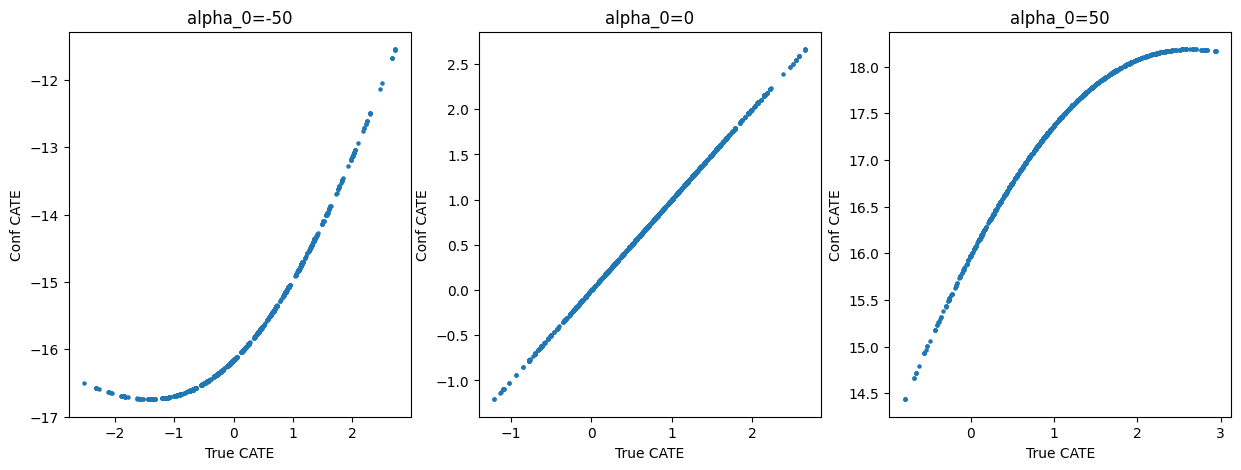

In [3]:
seed = 42
np.random.seed(seed)

dg = DataGenerator(n_features=10)

alpha_0_grid = [-50, 0, 50]
fig, ax = plt.subplots(1, len(alpha_0_grid), figsize=(15,5))

for i, alpha_0 in enumerate(alpha_0_grid):

    dg.alpha_0 = alpha_0
    dg.reset_coef()

    X, t, y, c, y0 = dg.generate_data(n=1000, is_exp=False)
    bias = dg.estimate_bias(X, n_per_x=10000)
    c_est = c + bias

    ax[i].scatter(c, c_est, s=5)
    ax[i].set_xlabel('True CATE')
    ax[i].set_ylabel('Conf CATE')
    ax[i].set_title(f'alpha_0={alpha_0}')

plt.show()

Below is the plot showing the confounding bias in relation to the true CATE when $\alpha_0=50$.

As the true CATE increases, the confounding bias first increases to a maximum and then decreases.

Text(0.5, 1.0, 'alpha_0=50')

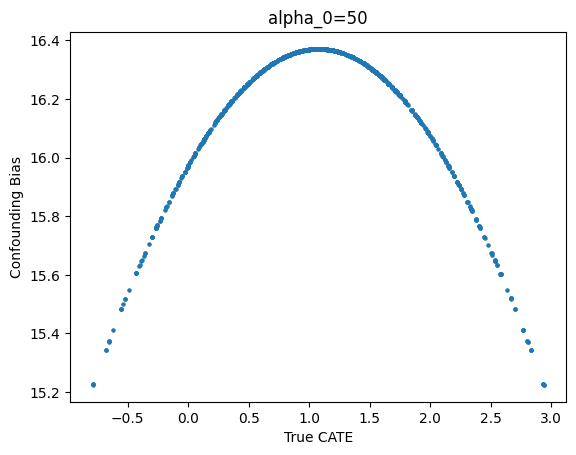

In [4]:
plt.scatter(c, bias, s=5)
plt.xlabel('True CATE')
plt.ylabel('Confounding Bias')
plt.title(f'alpha_0={dg.alpha_0}')

Below is an example to show the impact of $\epsilon^{\alpha}$ on the ranking. Non-zero values of $\sigma_{\alpha}$ clearly disrupt the ranking. However, the relationship between $\sigma_{\alpha}$ and the ranking correlation between true CATE and estimated CATE remains uncertain. This is because we observe that a $\sigma_{\alpha}$ of 5.0 does not intensify the confusion in the ranking compared to a $\sigma_{\alpha}$ of 1.0.

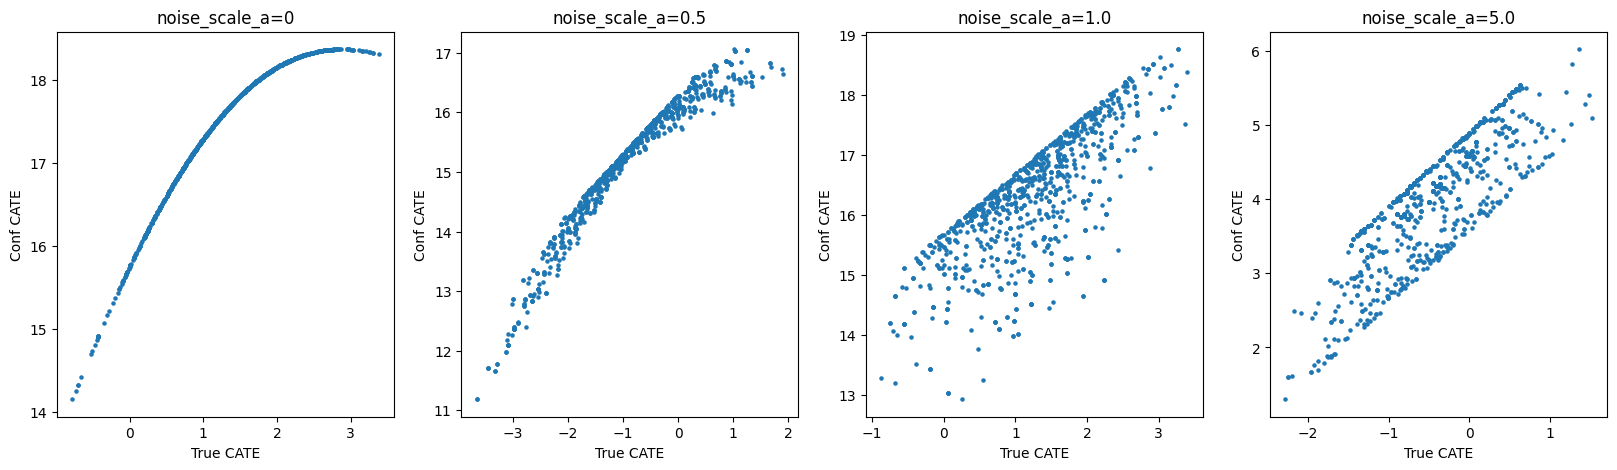

In [5]:
dg.alpha_0 = 50.0

noise_scale_a_grid = [0, 0.5, 1.0, 5.0]
fig, ax = plt.subplots(1, len(noise_scale_a_grid), figsize=(20,5))

for i, noise_scale_a in enumerate(noise_scale_a_grid):
    dg.noise_scale_a = noise_scale_a
    dg.reset_coef()

    X, t, y, c, y0 = dg.generate_data(n=1000, is_exp=False)

    bias = dg.estimate_bias(X, n_per_x=10000)
    c_est = c + bias

    ax[i].scatter(c, c_est, s=5)
    ax[i].set_xlabel('True CATE')
    ax[i].set_ylabel('Conf CATE')
    ax[i].set_title(f'noise_scale_a={noise_scale_a}') 

#### Experiment

We simulated a confounded data.

In [6]:
dg.reset_params(
    n_features=50,
    alpha_0=45.0,
    beta_0=0.0,
    theta=1.0,
    noise_scale_c=1.0, 
    noise_scale_y0=5.0,
    noise_scale_a=0.75,
    noise_scale_x=1.0
)
dg.reset_coef()
dg.beta_0 = -np.sum(dg.beta)*0.5+0.1

Text(0, 0.5, 'Conf CATE')

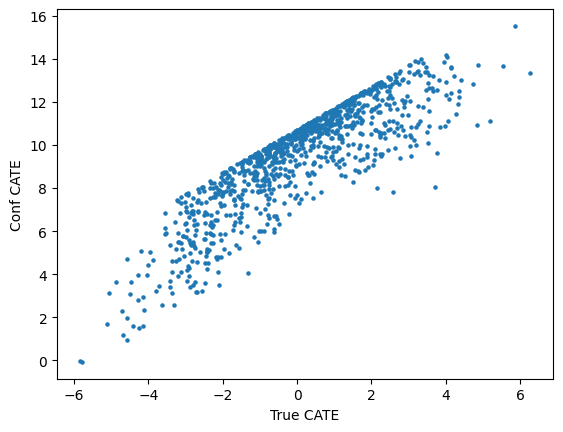

In [7]:
X, t, y, c, y0 = dg.generate_data(n=1000, is_exp=False)

bias = dg.estimate_bias(X, n_per_x=10000)
c_est = c + bias

plt.scatter(c, c_est, s=5)
plt.xlabel('True CATE')
plt.ylabel('Conf CATE')

In [8]:
## Observational data
n_obs = 50000
X_obs, t_obs, y_obs, c_obs, y0_obs = dg.generate_data(n_obs, is_exp=False)

## Test data (experimental data)
n_test = 10000
X_test, t_test, y_test, c_test, y0_test = dg.generate_data(n_test, is_exp=True)

Considering two scenarios:
* There is a large amoung of confounded observational data; 
* Only control data is available.

Two scoring models for the scenarios respectively: 
* A causal-effect model on the confounded data; 
* A predictive model on the control outcome.

In [9]:
def power2(min_num, max_num, base=1):

    grid = []
    num = base
    while num < min_num:
        num *= 2
    while num < max_num:
        grid.append(num)
        num *= 2
    return grid

def evaluate(cate, scores, n_bins=200):

    mse = mean_squared_error(cate, scores)
    auuc = auuc_score(cate, scores, n_bins)
    decisions = (scores > 0)
    causal_imp = causal_impact(cate, decisions)

    return mse, causal_imp, auuc

In [10]:
res_sm = []

# # Causal tree on confounded data
sm_cate = CausalTree(random_state=seed, min_samples_leaf=400)
sm_cate.fit(X_obs, np.c_[t_obs, y_obs])
conf_cate_pred = sm_cate.predict(X_test)

mse, causal_imp, auuc = evaluate(c_test, conf_cate_pred)
res_sm.append({'target': 'conf_cate', 'mse': mse, 'causal_imp': causal_imp, 'auuc': auuc})

# Decision tree for y0 
sm_y0 = DecisionTreeRegressor(random_state=seed, min_samples_leaf=400)
sm_y0.fit(X_obs, y0_obs)
y0_pred = sm_y0.predict(X_test)
res_sm.append({'target': 'y0', 'mse': mse, 'causal_imp': causal_imp, 'auuc': auuc})

res_df = pd.DataFrame(res_sm)
res_df.to_csv(f"../results/obs/scoring_model.csv", index=False)


Both scoring models perform better than the ATE, but there is still room for improvement compared to the true effects. The scoring model for Y0 performs better than the model for confounded CATE.

In [11]:
## Plots
def plot_uplift_curves(cate, scores_dict, n_bins=500):

    n = cate.shape[0]
    cate = np.array(cate)
    ate = cate.mean()
    plt.plot([0, n], [0, ate*n], label='Random')

    for label, scores in scores_dict.items():
        curve_values = uplift_curve(cate, scores, n_bins)
        plt.plot(curve_values[0], curve_values[1], label=label)

    plt.xlabel('Numer of targeted')
    plt.ylabel("Increment")
    plt.legend()
    plt.show()

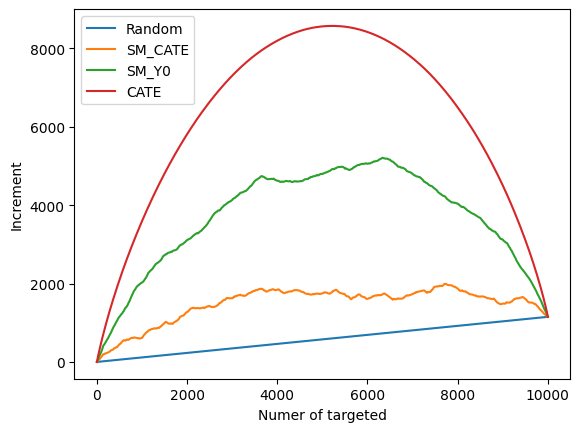

In [12]:
# Scoring model
scores_dict = {
    'SM_CATE': conf_cate_pred, 
    'SM_Y0': y0_pred,
    'CATE': c_test
}

plot_uplift_curves(c_test, scores_dict)


Deconfounders are built on scores and learn from the experimental data to predict corrections. There are three types of deconfounders, each with distinct optimization objective: (1) effect estimation (EE); (2) effect classification (EC); (3) effect ordering (EO). 

We compare the performance of deconfounders to a causal effect model that is learned from scratch using the experimental data. We vary the experimental data size and repeat experiments with different random seeds.

Three evaluation metrics:
* MSE of the CATE
* Causal impact: $P(d(X)=1)\cdot E[C(X)|d(X)=1]$, $d(x)$ is the decision policy, d(x)=1 if the score is greater than zero, otherwise $d(x)=0$
* AUUC (Area Under Uplift Curve)

In [13]:
def fit_causal_tree(X, t, y, tune=False, cv=5, seed=42, n_jobs=1):
    
    n = X.shape[0]
    model = CausalTree(random_state=seed)
    if tune:
        param_grid = {'min_samples_leaf': power2(16, n)}
        model_grid = GridSearchCV(model, param_grid, cv=cv, n_jobs=n_jobs)
        model_grid.fit(X, np.c_[t, y])
        # print("Best parameter:", model_grid.best_params_)
        model = model_grid.best_estimator_
    else:
        model.min_samples_leaf = min(250, int(0.1*n))
        model.fit(X, np.c_[t, y])
    return model

dcf_dict = {
    'EE': DeconfoundEstimator(),
    'EC': DeconfoundClassifier(),
    'EO': DeconfoundRanker(n_trees=10, n_levels=10, subsample=1, max_features=0.5)
}

def fit_deconfounder(X, t, y, scores, method='EE', tune=False, 
        cv=5, seed=42, n_jobs=1):

    n = X.shape[0]
    model = copy(dcf_dict[method])
    model.random_state = seed
    if tune:
        param_grid = {'min_samples_leaf': power2(16, n)}
        model_grid = GridSearchCV(model, param_grid, cv=cv, n_jobs=n_jobs)
        model_grid.fit(X, np.c_[t, y, scores])
        # print("Best parameter:", model_grid.best_params_)
        model = model_grid.best_estimator_
    else:
        if method == 'EO':
            model.min_samples_leaf = int(0.05 * n)
            model.max_buckets = max(200, int(0.1 * n)) 
        else:
            model.min_samples_leaf = min(250, int(0.1*n))
        model.fit(X, np.c_[t, y, scores])
    return model
    


In [14]:
dcf_types = ['EE', 'EC', 'EO']
targets = ['conf_cate', 'y0']

exp_size_grid = power2(100, 50000, base=100)

for seed in tqdm(range(20)):
    np.random.seed(seed)
    res = []
    for exp_size in exp_size_grid:
    
        # Generate data
        X_exp, t_exp, y_exp, eff_exp, y0_exp = dg.generate_data(exp_size, is_exp=True)

        # Causal tree
        ct = fit_causal_tree(X_exp, t_exp, y_exp, seed=seed)
        cate_pred = ct.predict(X_test)
        mse, causal_imp, auuc = evaluate(c_test, cate_pred)
        res.append({'model': 'CT', 'exp_size': exp_size, 'mse': mse,'causal_imp': causal_imp, 'auuc': auuc})

        # Deconfounder
        for dcf_type in dcf_types:
            for target in targets:
                if target == 'conf_cate':
                    scores = sm_cate.predict(X_exp)
                    scores_test = conf_cate_pred.copy()
                elif target == 'y0':
                    scores = sm_y0.predict(X_exp)
                    scores_test = y0_pred.copy()

                dm = fit_deconfounder(X_exp, t_exp, y_exp, scores, dcf_type, seed=seed)
                corrected_scores = scores_test - dm.predict(X_test)
                mse, causal_imp, auuc = evaluate(c_test, corrected_scores)
                model_name = f"{target}+{dcf_type}"  
                res.append({'model': model_name, 'exp_size': exp_size, 'mse': mse, 'causal_imp': causal_imp, 'auuc': auuc})
    
    res_df = pd.DataFrame(res)
    res_df.to_csv(f"../results/exp/{seed}.csv", index=False)


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [03:02<00:00,  9.11s/it]


Experimental Results for the following models:
* CT - Causal Tree
* SM (conf_cate) - Scoring model for confounded CATE
* SM (y0) - Scoring model for Y0
* EE, EC, EO - Deconfounder for effect estimation, effect classification, effect ordering respectively

In [15]:
res_sm = pd.read_csv("../results/obs/scoring_model.csv")

In [16]:
res_dir = "../results/exp"
res_df = pd.DataFrame()
for fname in os.listdir(res_dir):
    filepath = os.path.join(res_dir, fname)
    res_i = pd.read_csv(filepath)
    res_df = pd.concat([res_df, res_i])

res_df = res_df.groupby(by=['model', 'exp_size']).mean().reset_index()

In [17]:
exp_size_grid = power2(100, 50000, base=100)

# Add a horizontal line
def plot_metric_curve(metric, methods=['CT','EE', 'EC', 'EO']):

    targets = ['conf_cate', 'y0']

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    for i, target in enumerate(targets):
        ax[i].axhline(y=res_sm.loc[res_sm.target==target, metric].values[0], linestyle='--', color='black', label=f'{target}')
        for m in methods:
            if m == 'CT':
                ax[i].plot(range(len(exp_size_grid)), res_df.loc[res_df.model==m, metric], label=m)
            else:
                model_name = f"{target}+{m}" 
                ax[i].plot(range(len(exp_size_grid)), res_df.loc[res_df.model==model_name, metric], label=model_name)
        ax[i].set_ylabel(metric)
        ax[i].set_xlabel('Experimental data size (100 * 2^x)')
        ax[i].legend()
    plt.show()

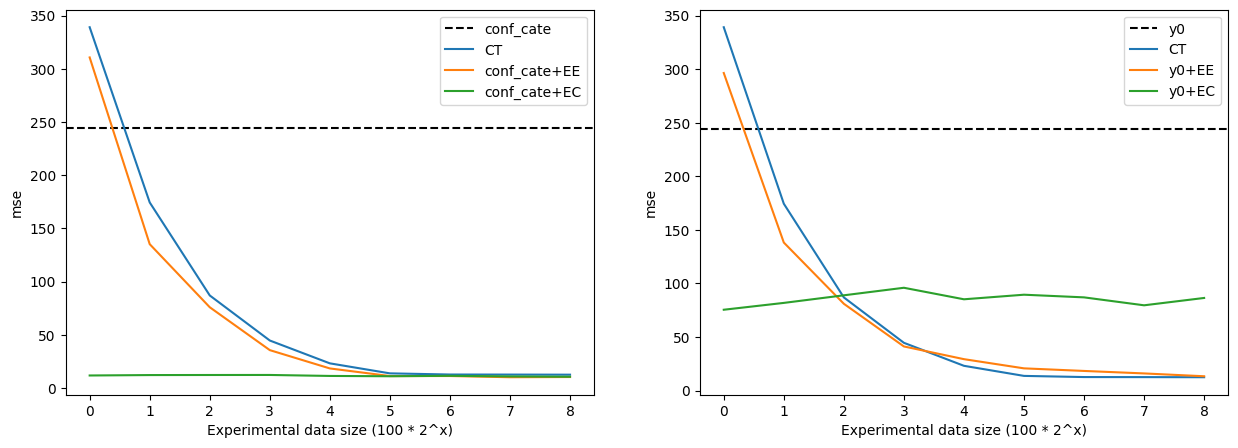

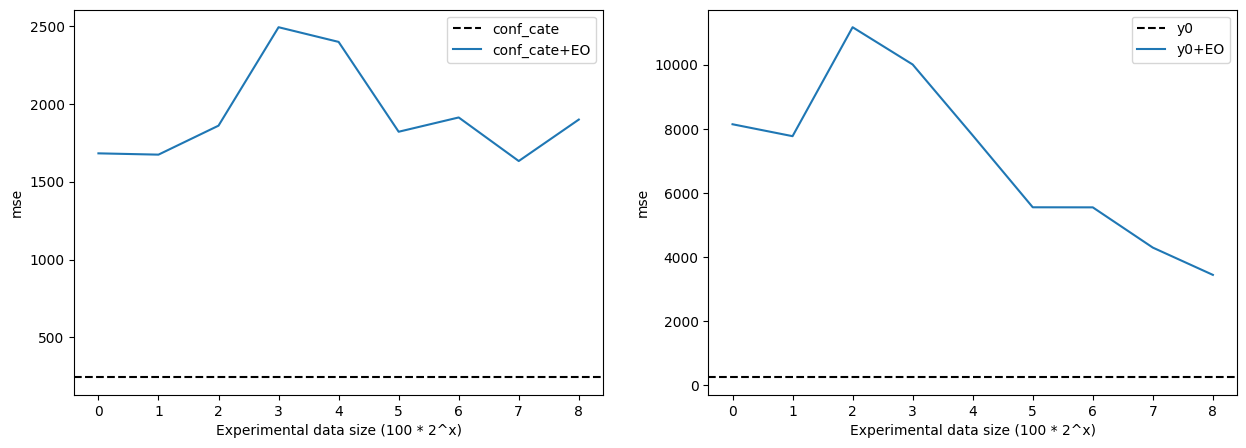

In [18]:
plot_metric_curve('mse', methods=['CT', 'EE', 'EC'])
plot_metric_curve('mse', methods=['EO'])

* The MSE of EE decreases with an increasing data size, and it is lower than SM model when the data size reaches about 200. 
* CT shows similar trend to EE. When the data size is small, CT's MSE is a bit higher than EE's. As the data size increases, CT shows almost equal or even lower MSE compared to EE.
* EO has a very large MSE, and there is no apparent correlation between its MSE and the data size.
* EC starts with the lowest MSE compared to other models, but its MSE shows minor fluctuations when the data size varies.


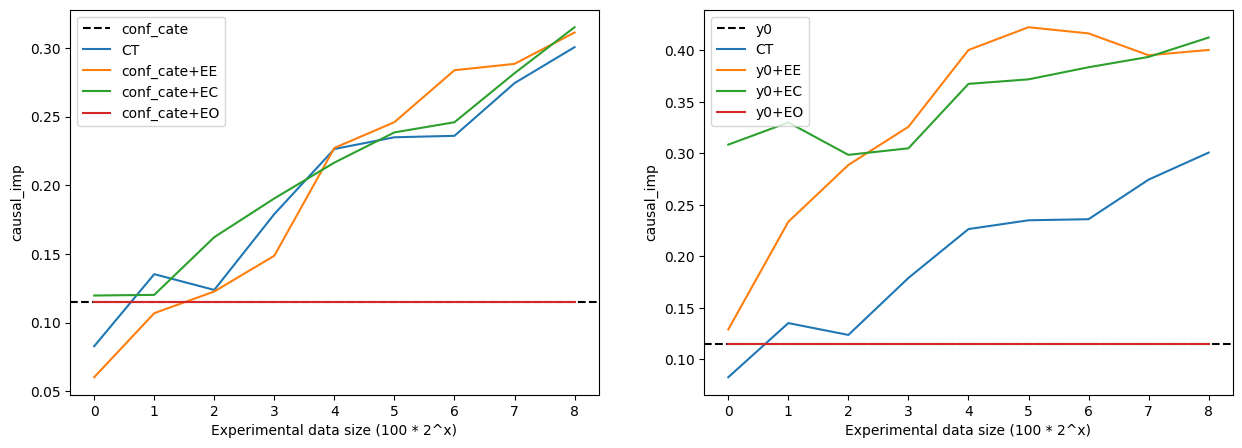

In [19]:
plot_metric_curve('causal_imp')

* EO keeps the same causal impact as the SM model regardless of the change in data size.
* CT, EE and EC models have already outperformed the SM model with a small data size. As the data size increases, the causal impact of these three models shows a rising trend along with intermittent fluctuations. These fluctuations may be caused by a fixed parameter setting that may not be the optimal choice for certain data sizes. Generally, EE and EC perform better than CT.

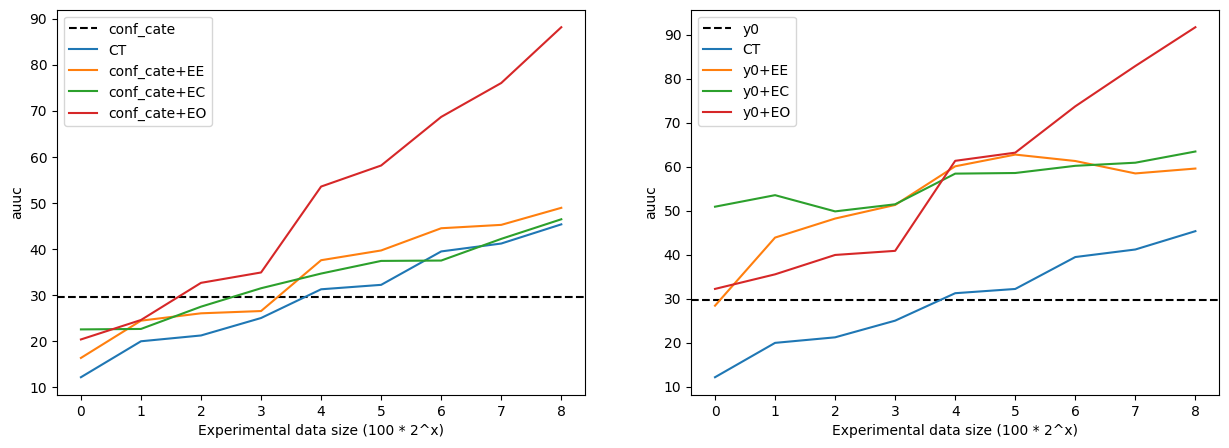

In [20]:
plot_metric_curve('auuc')

* All deconfounders surpass the SM models earlier compared to CT. 
* In general, EO demonstrates superior performance across all models.
* EE and EC models require a larger dataset to surpass the scoring model for predicting confounded CATE compared to surpassing the model for predicting y0.